# BD04 Data Science - Casus Anomaly Detection

#### Projectleden:
Chantal Favié, Kane Doornbos, Max Smeets, Sabrine Bouchmal

### Opdrachtgevers/begeleiders
Jan Baljan, Maarten Vaessen, Roel Bindels 


## Aanleiding

TODO: Omschrijven

Kinderen met de zeldzame spierziekte JDM (Juveniele Dermatomyositis) worden met behulp van de
Childhood Myositis Assessment Scale (CMAS) gemonitoord. Met de CMAS is het mogelijk om
spierzwakte te kunnen meten. De CMAS-meting is kort gezegd de maatstaaf die gebruikt wordt om
kinderen te meten met de zeldzame spierzwakte JDM. De kinderen moeten hiervoor frequent naar
het ziekenhuis voor behandelingen en de CMAS-meting. Door gebruik te maken van iDBPS kan de
meting op een laagdrempelige manier thuis worden uitgevoerd. Er wordt voor deze meting door
iDBPS alleen gebruik gemaakt van een camera, zoals deze aanwezig is in de huidige laptops en
mobiele telefoons. Hiervoor wordt gebruik gemaakt van kunstmatige intelligentie die de
lichaamshouding analyseert. De oefeningen kunnen dan door het kind thuis worden uitgevoerd.
De pipeline voor iDBPS bestaat uit 2 delen. In het eerste deel wordt een AI model ingezet om op
basis van een camera beeld de persoon en de postitie van de lichaamsdelen te herkennen. In het 2e
deel worden deze informatie gebruikt om een bepaalde lichaamshouding te herkennen en
automatisch te scoren. Voor dit 2e deel is het belangrijk dat de data uit de lichaamsherkenning
betrouwbaar en van hoge kwaliteit is. Bij de huidige AI modellen is dit niet altijd het geval en hier
zoeken wij een oplossing voor.

## Doelstelling

TODO: Omschrijven

Het doel van de casus is het onderzoeken, ontwerpen en realiseren van een methode die als input
de output van een lichaamsherkenning AI-model neemt en 1) bepaald of deze betrouwbaar en van
hoge kwaliteit is, 2) zo mogelijk, deze "repareert" en alsnog bruikbaar maakt voor de rest van de
pipeline.


## Rauwe data
Voor de rauwe data worden video opnamens gemaakt van bepaalde fysieke bewegingen.
Videodata wordt vervolgens geanalyseerd door een pose detectie model waar diverse herkenningspunten op het lichaam geregistreerd worden. Dit resulteert in een json bestand waar voor elk herkenningspunt op vaste intervals de x en y coordinaat binnen het canvas opgeslagen worden.

Een voorbeeld momentopname van een herkenningspunt ziet er als volgt uit:
```
{
        "_index": "logstash-2021.03.10-000001",
        "_type": "_doc",
        "_id": "Kw1eHHgBhLy4-w68XmUL",
        "_score": 1.0,
        "_source": {
                "frameDate": "2021-03-10T13:40:49.336Z",
                "y": 256.41362694914704,
                "x": 371.01454493600573,
                "keypointName": "leftElbow",
                "keypointScore": 0.8112194538116455,
                "@version": "1",
                "frameScore": 0.644375700284453,
                "testStart": "2021-03-10T13:40:45.594Z",
                "elapsedSeconds": 3875,
                "@timestamp": "2021-03-10T13:40:49.773Z"
        }
}
```

## Data retrieval

In [2]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json

In [3]:
# Increase max columns
pd.set_option('display.max_columns',100)

In [4]:
#Define file locations and empty dataframe
files = [
            './data/Testpersoon-D/D-Zit1.json', 
            './data/Testpersoon-D/D-Zit2.json', 
            './data/Testpersoon-D/D-Zit3.json',
            './data/Testpersoon-D/D-Zit4.json',
            './data/Testpersoon-D/D-Zit5.json'
        ]

df = pd.DataFrame([])

# Concatinate json files to dataframe
for file in range(len(files)):
    with open(files[file]) as data_file:
        data = json.load(data_file)
        df = pd.concat([df, pd.json_normalize(data['hits']['hits'])])
df

,_index,_type,_id,_score,_source.frameDate,_source.y,_source.x,_source.keypointName,_source.keypointScore,_source.@version,_source.frameScore,_source.testStart,_source.elapsedSeconds,_source.@timestamp
0,logstash-2021.03.10-000001,_doc,OQ1QHHgBhLy4-w68VDSV,1.0,2021-03-10T13:25:29.142Z,333.633155,285.758741,rightKnee,0.994406,1,0.941125,2021-03-10T13:25:25.288Z,3963,2021-03-10T13:25:29.630Z
1,logstash-2021.03.10-000001,_doc,Og1QHHgBhLy4-w68VDSV,1.0,2021-03-10T13:25:29.142Z,247.039533,263.028280,rightWrist,0.998403,1,0.941125,2021-03-10T13:25:25.288Z,3963,2021-03-10T13:25:29.632Z
2,logstash-2021.03.10-000001,_doc,Ow1QHHgBhLy4-w68VDSV,1.0,2021-03-10T13:25:29.142Z,127.600087,284.910068,rightShoulder,0.998896,1,0.941125,2021-03-10T13:25:25.288Z,3963,2021-03-10T13:25:29.634Z
3,logstash-2021.03.10-000001,_doc,PA1QHHgBhLy4-w68VDSV,1.0,2021-03-10T13:25:29.142Z,72.860357,309.362101,rightEye,0.990845,1,0.941125,2021-03-10T13:25:25.288Z,3963,2021-03-10T13:25:29.635Z
4,logstash-2021.03.10-000001,_doc,PQ1QHHgBhLy4-w68VDSV,1.0,2021-03-10T13:25:29.012Z,422.327084,358.200198,leftAnkle,0.727294,1,0.939658,2021-03-10T13:25:25.288Z,3963,2021-03-10T13:25:29.637Z
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
658,logstash-2021.03.10-000001,_doc,1w1THHgBhLy4-w68Gz4N,1.0,2021-03-10T13:28:27.547Z,205.629069,257.848701,rightElbow,0.968070,1,0.885256,2021-03-10T13:28:26.493Z,4738,2021-03-10T13:28:31.697Z
659,logstash-2021.03.10-000001,_doc,uQ1THHgBhLy4-w68Gz4A,1.0,2021-03-10T13:28:28.475Z,163.412351,328.019236,leftEar,0.595790,1,0.875168,2021-03-10T13:28:26.493Z,4738,2021-03-10T13:28:31.681Z
660,logstash-2021.03.10-000001,_doc,3A1THHgBhLy4-w68Gz4N,1.0,2021-03-10T13:28:27.547Z,160.321940,333.302835,leftEar,0.595728,1,0.885256,2021-03-10T13:28:26.493Z,4738,2021-03-10T13:28:31.697Z
661,logstash-2021.03.10-000001,_doc,wA1THHgBhLy4-w68Gz4A,1.0,2021-03-10T13:28:28.240Z,200.846319,444.508343,leftWrist,0.840393,1,0.890357,2021-03-10T13:28:26.493Z,4738,2021-03-10T13:28:31.684Z


In [5]:
# Dataframe column types
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2465 entries, 0 to 662
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   _index                  2465 non-null   object 
 1   _type                   2465 non-null   object 
 2   _id                     2465 non-null   object 
 3   _score                  2465 non-null   float64
 4   _source.frameDate       2465 non-null   object 
 5   _source.y               2465 non-null   float64
 6   _source.x               2465 non-null   float64
 7   _source.keypointName    2465 non-null   object 
 8   _source.keypointScore   2465 non-null   float64
 9   _source.@version        2465 non-null   object 
 10  _source.frameScore      2465 non-null   float64
 11  _source.testStart       2465 non-null   object 
 12  _source.elapsedSeconds  2465 non-null   int64  
 13  _source.@timestamp      2465 non-null   object 
dtypes: float64(5), int64(1), object(8)
memory

In [6]:
# Keypoint score statistics
df['_source.keypointScore'].describe()

count    2465.000000
mean        0.929341
std         0.131412
min         0.085863
25%         0.947255
50%         0.989869
75%         0.996336
max         0.999532
Name: _source.keypointScore, dtype: float64

In [7]:
# Frame score statistics
df['_source.frameScore'].describe()

count    2465.000000
mean        0.929341
std         0.023352
min         0.822820
25%         0.921633
50%         0.938448
75%         0.942940
max         0.957771
Name: _source.frameScore, dtype: float64

In [8]:
# Drop non computable numeric values
df = df.drop(axis=1, labels=['_score', '_source.y', '_source.x', '_source.elapsedSeconds'])

In [9]:
# Get mean keypoint and frame scores for every keypoint
df_means = df.groupby('_source.keypointName').mean(numeric_only=True)
df_means = df_means.reset_index()

df_means

,_source.keypointName,_source.keypointScore,_source.frameScore
0,leftAnkle,0.853694,0.929341
1,leftEar,0.625317,0.929341
2,leftElbow,0.982530,0.929341
3,leftEye,0.979098,0.929341
4,leftHip,0.998105,0.929341
5,leftKnee,0.988634,0.929341
6,leftShoulder,0.996285,0.929341
7,leftWrist,0.945458,0.929341
8,nose,0.992540,0.929341
9,rightAnkle,0.879848,0.929341


In [10]:
# Checking for missing values
df.isna().sum()


_index                   0
_type                    0
_id                      0
_source.frameDate        0
_source.keypointName     0
_source.keypointScore    0
_source.@version         0
_source.frameScore       0
_source.testStart        0
_source.@timestamp       0
dtype: int64

In [11]:
# Score fetcher
def fetchScore(df, i):
    if i >= len(df):
        plt.xlabel('Keypoint score')
        plt.ylabel('Frame score')
        plt.show()
    else:
        plt.scatter(df['_source.keypointScore'][i],df['_source.frameScore'][i])
        fetchScore(df, i+1)
 

## Data cleaning

## Data visualisation

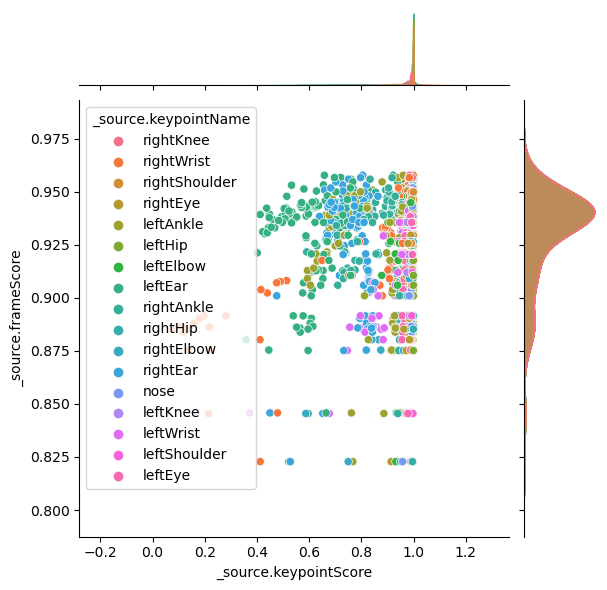

In [12]:
# Categorical jointplot
sns.jointplot(data=df, x="_source.keypointScore", y="_source.frameScore", hue='_source.keypointName')

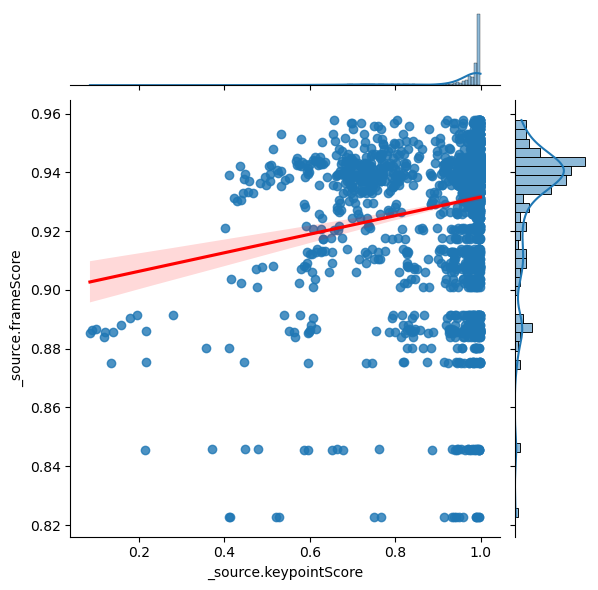

In [13]:
# Joint plot with regression line
sns.jointplot(data=df, x="_source.keypointScore", y="_source.frameScore", kind="reg", joint_kws={"line_kws":{'color':'red'}})

c:\Users\maxsm\miniconda3\envs\b2c3\lib\site-packages\pandas\plotting\_matplotlib\core.py:807: UserWarning: The handle <BarContainer object of 17 artists> has a label of '_source.keypointScore' which cannot be automatically added to the legend.
  ax.legend(handles, labels, loc="best", title=title)
c:\Users\maxsm\miniconda3\envs\b2c3\lib\site-packages\pandas\plotting\_matplotlib\core.py:807: UserWarning: The handle <BarContainer object of 17 artists> has a label of '_source.frameScore' which cannot be automatically added to the legend.
  ax.legend(handles, labels, loc="best", title=title)


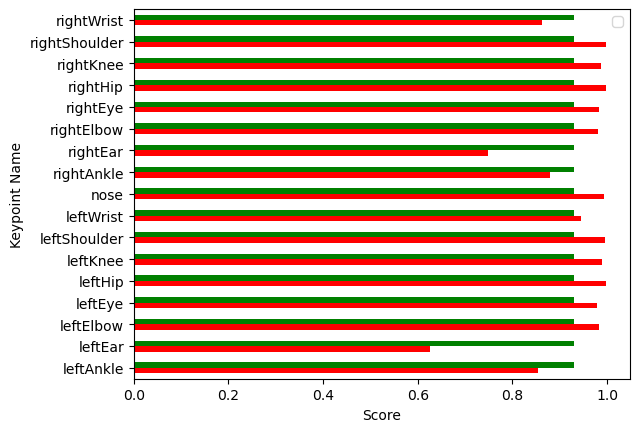

In [18]:
# Bar chart for mean keypoint values
ax = df_means.plot.barh(x='_source.keypointName', 
                        color={'_source.keypointScore': 'red', 
                               '_source.frameScore': 'green'
                            },  
                        legend = True, 
                        ylabel="Keypoint Name", 
                        xlabel="Score")


## Model

TODO: Analyse schrijven voor meest geschikte model

- PoseNet ( ? )
- Mediapipe ( ? )
- MoveNet Lightning (Performance > Accuracy)
- MoveNet Thunder (Accuracy > Performance)

## Aantekeningen meeting week 2
- POSENET tensorflow library voor oefeningen gebruikt
- Ook andere modellen mogelijk (mediapipe)
- Model zsm draaiende hebben, dan zelf video opnamens maken
- Kibana (dashboard voor data te bekijken)